# Speech Emotion Recognition

---



## Loading dataset from Kaggle

In [3]:
from google.colab import drive
drive.mount('/content/drive')

! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download ejlok1/toronto-emotional-speech-set-tess
! unzip toronto-emotional-speech-set-tess

Streaming output truncated to the last 5000 lines.
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_back_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bar_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_base_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bath_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bean_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_beg_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bite_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_boat_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bone_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_book_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bought_angry.wav  
  inflating: TESS Toronto emotional 

In [7]:
import pandas as pd
import numpy as np
import shutil

import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

paths=[]
labels=[]
for dirname, _, filenames in os.walk('TESS Toronto emotional speech set data'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename[::-1].split('_')[0][::-1]
        labels.append(label.lower())

df = pd.DataFrame({'speech':paths,'label':labels})
df

,speech,label
0,TESS Toronto emotional speech set data/YAF_fea...,fear.wav
1,TESS Toronto emotional speech set data/YAF_fea...,fear.wav
2,TESS Toronto emotional speech set data/YAF_fea...,fear.wav
3,TESS Toronto emotional speech set data/YAF_fea...,fear.wav
4,TESS Toronto emotional speech set data/YAF_fea...,fear.wav
...,...,...
2795,TESS Toronto emotional speech set data/YAF_ple...,ps.wav
2796,TESS Toronto emotional speech set data/YAF_ple...,ps.wav
2797,TESS Toronto emotional speech set data/YAF_ple...,ps.wav
2798,TESS Toronto emotional speech set data/YAF_ple...,ps.wav


## Plotting Wave Plot and Spectrogram of different emotions

fear.wav
<class 'str'>


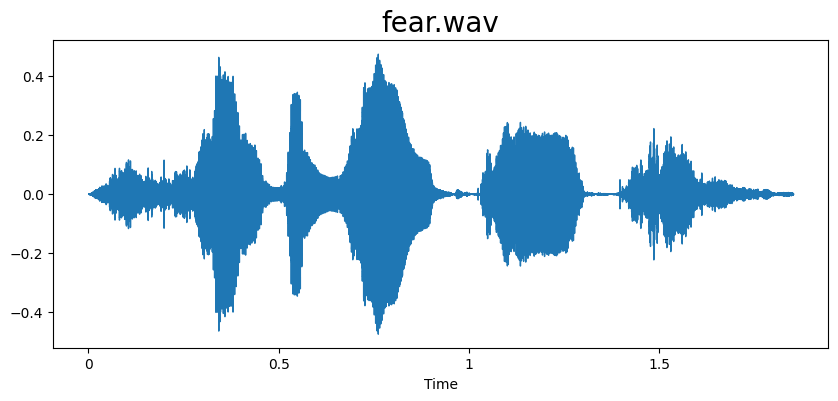

None

neutral.wav
<class 'str'>


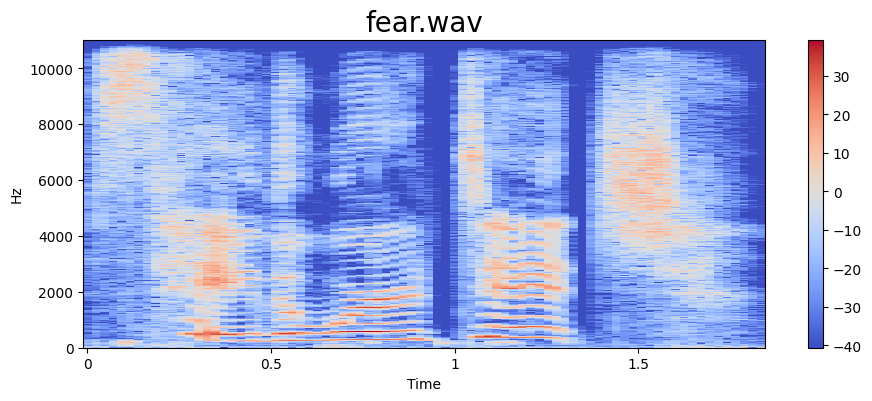

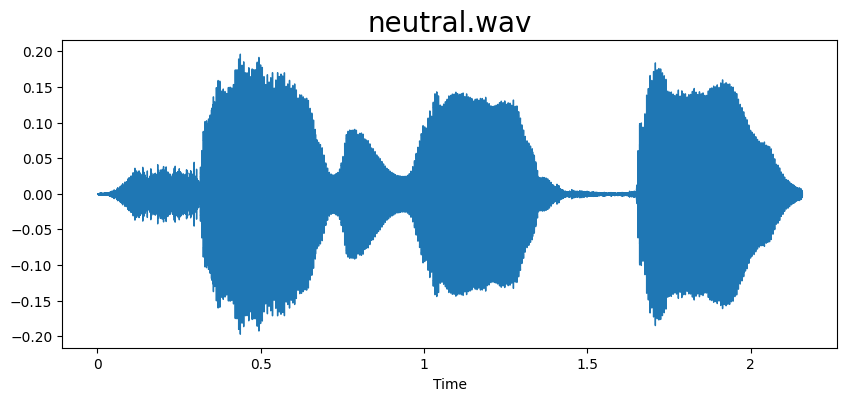

None

ps.wav
<class 'str'>


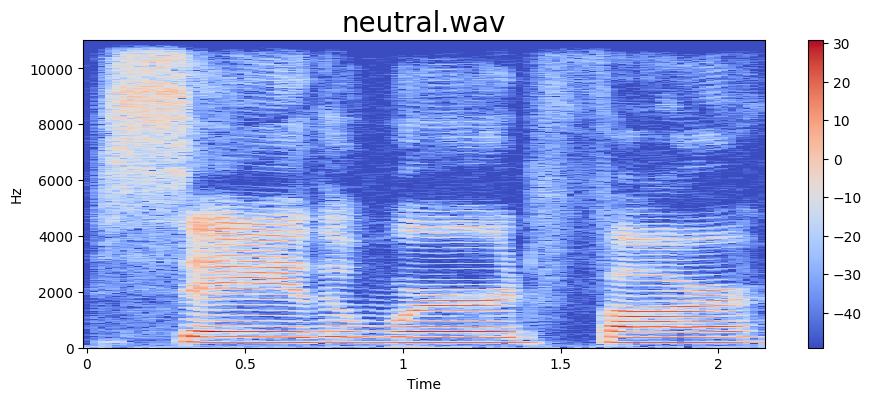

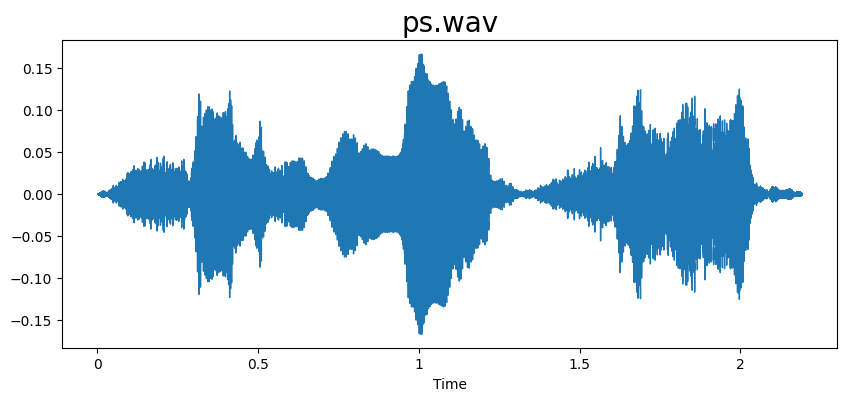

None

disgust.wav
<class 'str'>


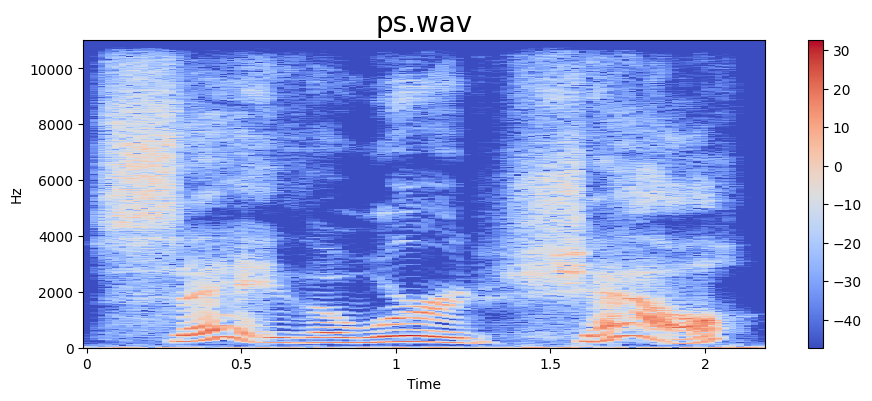

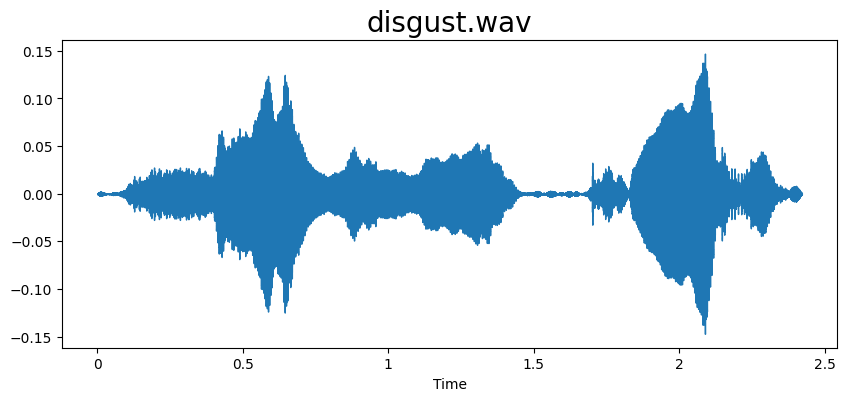

None

sad.wav
<class 'str'>


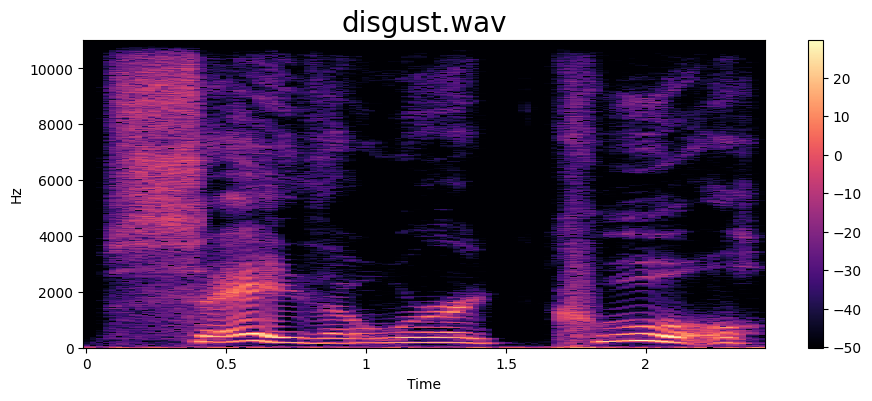

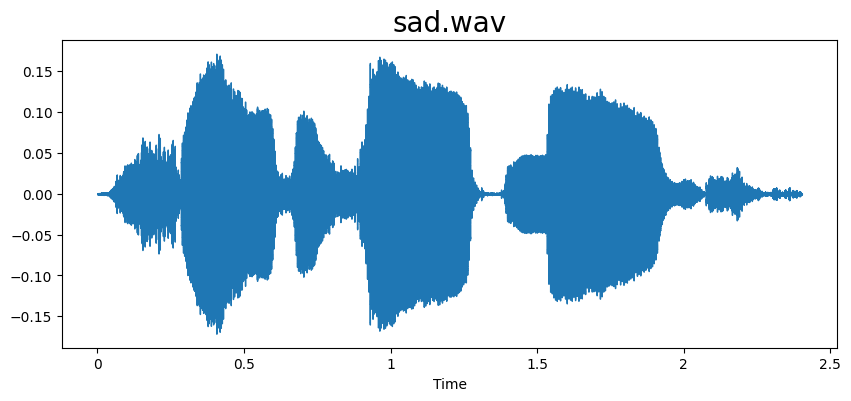

None

angry.wav
<class 'str'>


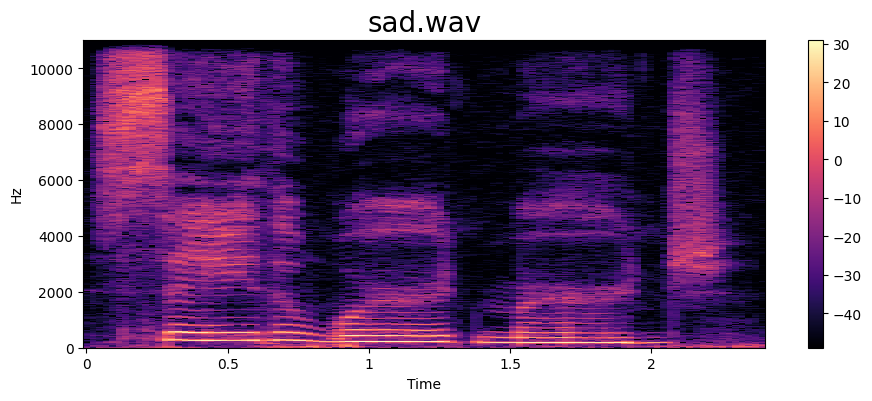

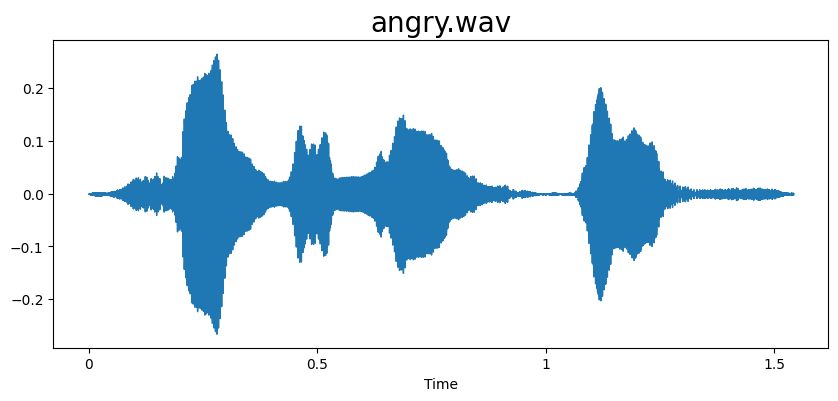

None

happy.wav
<class 'str'>


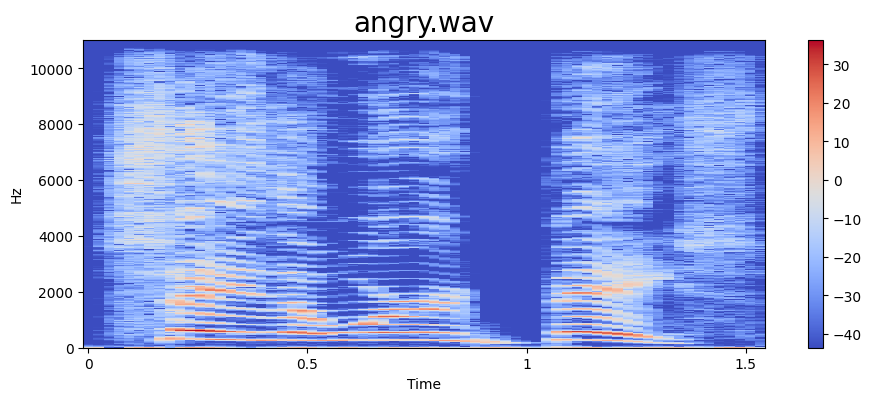

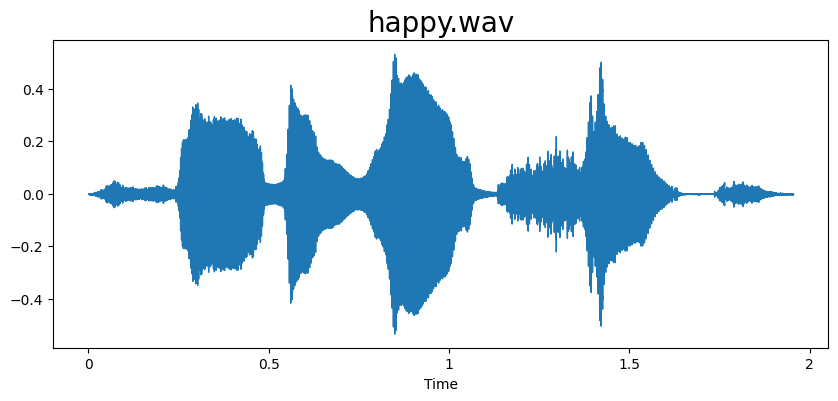

None

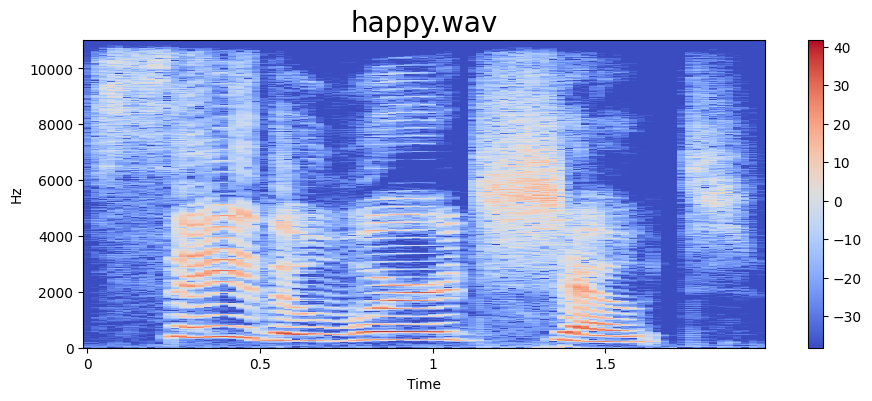

In [8]:
def waveplot(data,sr,emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion,size=20)
    librosa.display.waveshow(data,sr=sr)
    plt.show()

def spectogram(data,sr,emotion):
    x=librosa.stft(data)                 #Short Fourior Transform of Original Data
    xdb=librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion,size=20)
    librosa.display.specshow(xdb,sr=sr,x_axis='time',y_axis='hz')
    plt.colorbar()

def ana_emotion(emotion:str, df:pd.DataFrame):
    print(emotion)
    print(str)
    path=np.array(df['speech'][df['label']==emotion])[0]
    data,sampling_rate=librosa.load(path)
    waveplot(data,sampling_rate,emotion)
    spectogram(data,sampling_rate,emotion)
    display(Audio(path))

for i in list(df['label'].unique()):
    display(ana_emotion(i, df))

## Feature Extraction

In [9]:
def extract_features(filename):
    y, sr = librosa.load(filename, sr=None)

    # Extract features
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    energy = np.mean(librosa.feature.rms(y=y))
    pitch, _ = librosa.piptrack(y=y, sr=sr, fmin=75, fmax=1600)
    pitch = np.mean(pitch)

    # Concatenate features into one array
    features = np.concatenate((mfccs, spectral_centroid, spectral_bandwidth, spectral_contrast, spectral_rolloff, zero_crossing_rate, chroma), axis=0)
    features = np.append(features, energy)
    features = np.append(features, pitch)

    return features

# Extract features for all audio files in dataframe
X_features = df['speech'].apply(lambda x:extract_features(x))
X_features_array = np.array(X_features.tolist())

np.save('X_features.npy', X_features_array)
X_features = np.load('X_features.npy',allow_pickle=True)
print('Shape of X_features', X_features.shape)
X = np.expand_dims(X_features, -1)

Shape of X_features 2 (2800,)


In [13]:
X_features = np.load('X_features.npy',allow_pickle=True)
X = np.expand_dims(X_features, -1)
max_len = max(len(x[0]) for x in X)
X_padded = np.zeros((len(X), max_len), dtype=np.float32)
for i, x in enumerate(X):
    X_padded[i, :len(x[0])] = x[0]
X = X_padded.reshape(X_padded.shape[0], X_padded.shape[1], 1)

print('Shape of X', X.shape)
print('Data Type = ', X.dtype)

Shape of X (2800, 10226, 1)
Data Type =  float32


In [25]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])
y = y.toarray()
print('Shape of y = ', y.shape)

Shape of y =  (2800, 7)


In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size =.90)
print('Shape of X = ', X.shape)
print('Shape of Y = ', y.shape)
print('Shape of X_train = ', X_train.shape)
print('Shape of y_train = ', y_train.shape)
print('Shape of X_test = ',  X_test.shape)
print('Shape of Y_test = ', y_test.shape)
# check the type of each array
print("========================")
print('Type of X = ', type(X))
print('Type of Y = ', type(y))
print('Type of X_train = ', type(X_train))
print('Type of y_train = ', type(y_train))
print('Type of X_test = ',  type(X_test))
print('Type of Y_test = ', type(y_test))

Shape of X =  (2800, 10226, 1)
Shape of Y =  (2800, 7)
Shape of X_train =  (2520, 10226, 1)
Shape of y_train =  (2520, 7)
Shape of X_test =  (280, 10226, 1)
Shape of Y_test =  (280, 7)
Type of X =  <class 'numpy.ndarray'>
Type of Y =  <class 'numpy.ndarray'>
Type of X_train =  <class 'numpy.ndarray'>
Type of y_train =  <class 'numpy.ndarray'>
Type of X_test =  <class 'numpy.ndarray'>
Type of Y_test =  <class 'numpy.ndarray'>


## Model Training and Evaluation

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size =.90)

# Reshape data to 2D for scaling
y = y.ravel()
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))

# Create a scaler object and fit on training data
scaler = StandardScaler()
scaler.fit(X_train)

# Transform the training and testing data using the scaler
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the classifiers
svm_clf = make_pipeline(StandardScaler(), SVC())
lr_clf = make_pipeline(StandardScaler(), LogisticRegression())
rf_clf = RandomForestClassifier()
knn_clf = KNeighborsClassifier()
mlp_clf = MLPClassifier()

classifiers = {'SVM': svm_clf, 'Logistic Regression': lr_clf, 'Random Forest': rf_clf, 'KNN' :knn_clf, 'MLP': mlp_clf}

for clf_name, clf in classifiers.items():
    print("Classifier:", clf_name)
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy:", acc)
    cm = pd.DataFrame(index = [i for i in enc.categories_] , columns = [i for i in enc.categories_])
    print(classification_report(y_test, y_pred))

Classifier: SVM
Accuracy: 0.7392857142857143
              precision    recall  f1-score   support

           0       0.81      0.71      0.75        41
           1       0.84      0.82      0.83        33
           2       0.65      0.62      0.63        39
           3       0.63      0.68      0.65        47
           4       0.85      0.96      0.90        47
           5       0.47      0.54      0.51        35
           6       1.00      0.82      0.90        38

    accuracy                           0.74       280
   macro avg       0.75      0.73      0.74       280
weighted avg       0.75      0.74      0.74       280

Classifier: Logistic Regression
Accuracy: 0.8321428571428572
              precision    recall  f1-score   support

           0       0.80      0.88      0.84        41
           1       0.93      0.82      0.87        33
           2       0.86      0.77      0.81        39
           3       0.79      0.70      0.74        47
           4       0.96   

MLP classifier performs the best.

## Building a CNN Model

In [27]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Define model architecture
model = Sequential([
    Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(10226, 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=256, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 10222, 64)         384       
                                                                 
 max_pooling1d_12 (MaxPooli  (None, 5111, 64)          0         
 ng1D)                                                           
                                                                 
 dropout_16 (Dropout)        (None, 5111, 64)          0         
                                                                 
 conv1d_13 (Conv1D)          (None, 5107, 128)         41088     
                                                                 
 max_pooling1d_13 (MaxPooli  (None, 2553, 128)         0         
 ng1D)                                                           
                                                                 
 dropout_17 (Dropout)        (None, 2553, 128)        

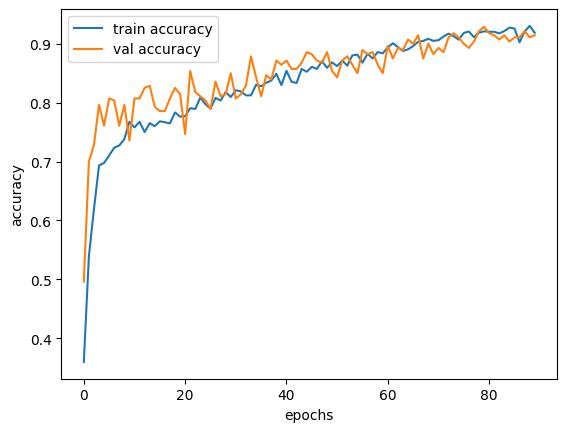

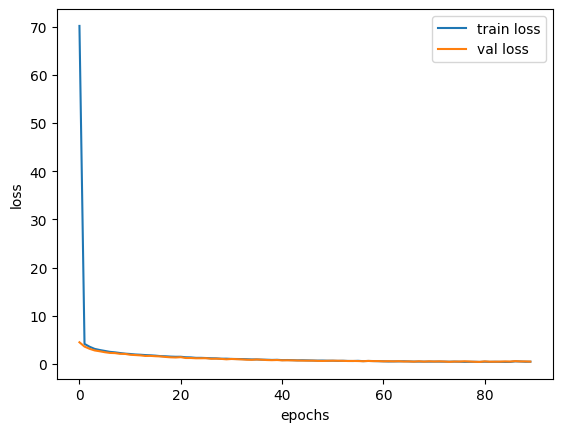

In [28]:
epochs = list(range(90))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [29]:
print('Shape of X_test = ',  X_test.shape)
print('Shape of Y_test = ', y_test.shape)
y_pred = model.predict(X_test)
print('Shape of Y_pred = ', y_pred.shape)

Shape of X_test =  (280, 10226, 1)
Shape of Y_test =  (280, 7)
9/9 [==============================] - 1s 33ms/step
Shape of Y_pred =  (280, 7)


In [30]:
# Predicting on test data.
pred_test = model.predict(X_test)
y_pred = enc.inverse_transform(pred_test)
y_test = enc.inverse_transform(y_test)

print(y_pred.shape)
print(y_test.shape)

9/9 [==============================] - 0s 28ms/step
(280, 1)
(280, 1)


In [31]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()
df

,Predicted Labels,Actual Labels
0,angry.wav,angry.wav
1,fear.wav,fear.wav
2,neutral.wav,neutral.wav
3,happy.wav,happy.wav
4,angry.wav,angry.wav
...,...,...
275,happy.wav,happy.wav
276,ps.wav,ps.wav
277,angry.wav,angry.wav
278,disgust.wav,disgust.wav


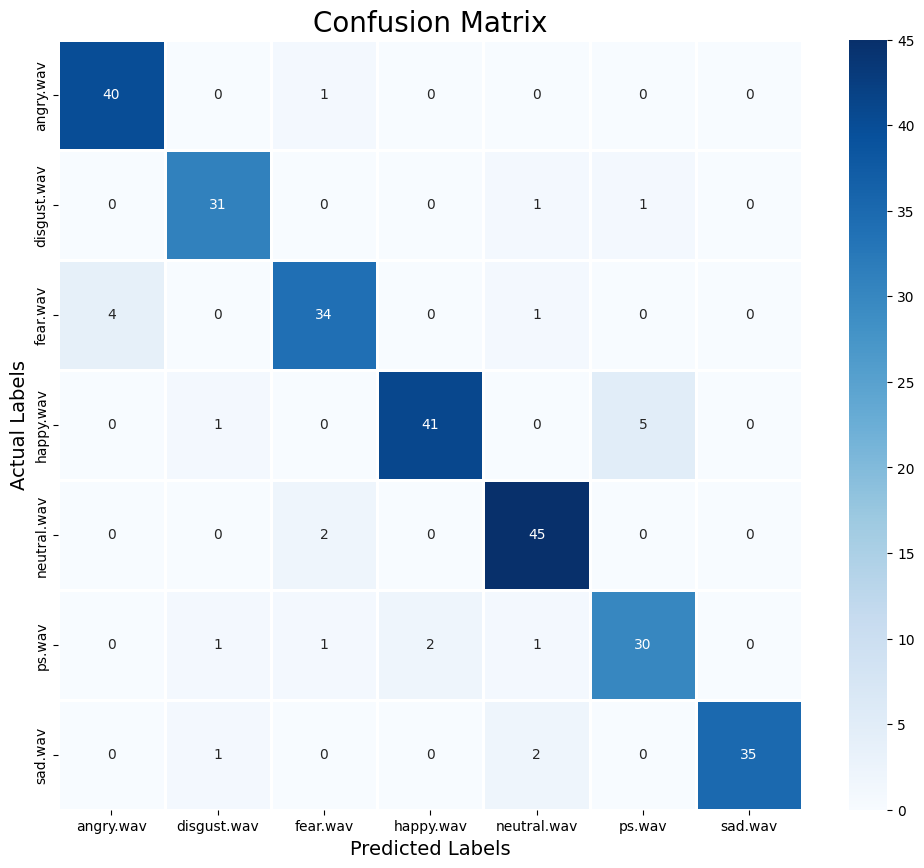

In [32]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in enc.categories_] , columns = [i for i in enc.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   angry.wav       0.91      0.98      0.94        41
 disgust.wav       0.91      0.94      0.93        33
    fear.wav       0.89      0.87      0.88        39
   happy.wav       0.95      0.87      0.91        47
 neutral.wav       0.90      0.96      0.93        47
      ps.wav       0.83      0.86      0.85        35
     sad.wav       1.00      0.92      0.96        38

    accuracy                           0.91       280
   macro avg       0.91      0.91      0.91       280
weighted avg       0.92      0.91      0.91       280



Overall, the CNN model performs the best for speech emotion recognition and can be developed further.